<h align="center">

# Fraudulent Review Detection

</h>


## Data importing

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
df = pd.read_csv('fake reviews dataset.csv')
df.head()

,category,rating,label,text_
0,Home_and_Kitchen_5,5.0,CG,"Love this! Well made, sturdy, and very comfor..."
1,Home_and_Kitchen_5,5.0,CG,"love it, a great upgrade from the original. I..."
2,Home_and_Kitchen_5,5.0,CG,This pillow saved my back. I love the look and...
3,Home_and_Kitchen_5,1.0,CG,"Missing information on how to use it, but it i..."
4,Home_and_Kitchen_5,5.0,CG,Very nice set. Good quality. We have had the s...


<p>The generated fake reviews dataset, containing 20k fake reviews and 20k real product reviews. OR = Original reviews (presumably human created and authentic); CG = Computer-generated fake reviews.

<b>Acknowlegement:
Foto von Brett Jordan auf Unsplash</b>
</p>

In [3]:
df.shape

(40432, 4)

In [4]:
df['label'].value_counts(normalize = True)

label
CG    0.5
OR    0.5
Name: proportion, dtype: float64

<p>So that the data is balanced when it comes to being a fake review or not.</p>

In [5]:
df['rating'].value_counts(normalize = True)

rating
5.0    0.607415
4.0    0.196997
3.0    0.093639
1.0    0.053299
2.0    0.048650
Name: proportion, dtype: float64

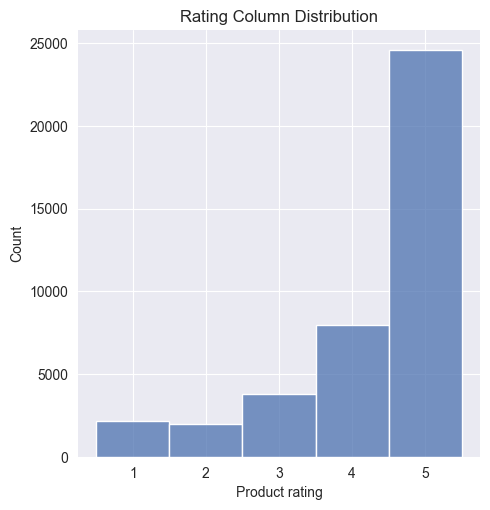

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_color_codes()
sns.set_style("darkgrid")
ax = sns.displot(df, x="rating", discrete=True, color ='b')
sns.despine(left=True, bottom=True)
plt.title("Rating Column Distribution")
plt.xlabel('Product rating')
plt.ylabel('Count')
plt.show()

## Text Preprocessing

In [7]:
import string
import nltk
from nltk.stem import PorterStemmer, WordNetLemmatizer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rmanm\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rmanm\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\rmanm\AppData\Roaming\nltk_data...


In [8]:
def preprocess_text(input_text):
    # Remove punctuation
    text_no_punctuation = "".join([char for char in input_text if char not in string.punctuation])
    # Split into words
    words = text_no_punctuation.split()
    # Remove stopwords
    meaningful_words = [word for word in words if word.lower() not in stopwords.words('english')]
    # Stemming
    stemmer = PorterStemmer()
    stemmed_words = [stemmer.stem(word) for word in meaningful_words]
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in stemmed_words]
    # Join words back into string
    result = " ".join(lemmatized_words)
    return result

In [9]:
df['text_'] = df['text_'].astype(str).apply(preprocess_text)
df['text_'].head()

0    love well made sturdi comfort love itveri pretti
1        love great upgrad origin ive mine coupl year
2              pillow save back love look feel pillow
3                 miss inform use great product price
4                 nice set good qualiti set two month
Name: text_, dtype: object

In [10]:
if df.isnull().values.any():
    num_rows_with_nan = df.isnull().any(axis=1).sum()
    print(f'There are {num_rows_with_nan} rows with NaN values in the DataFrame.')
    df = df.dropna()
    print('Rows with NaN values have been removed.')
else:
    print('There are no NaN values in the DataFrame.')

There are no NaN values in the DataFrame.


## Text Length Analysis and Visualization by Label Grouping

In [11]:
df['length'] = df['text_'].apply(len)

### histogram of text length

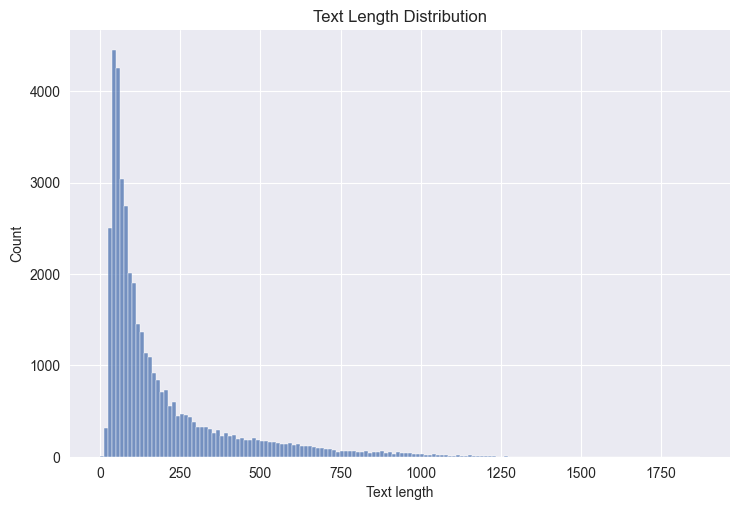

In [12]:
sns.set_color_codes()
sns.set_style("darkgrid")
ax = sns.displot(df, x="length", bins=150, color ='b', aspect=1.5)
sns.despine(left=True, bottom=True)
plt.title("Text Length Distribution")
plt.xlabel('Text length')
plt.ylabel('Count')
plt.show()

### Display descriptive statistics

In [13]:
df.groupby('label').describe()

rating                                                length  \
         count      mean       std  min  25%  50%  75%  max    count   
label                                                                  
CG     20216.0  4.259893  1.141065  1.0  4.0  5.0  5.0  5.0  20216.0   
OR     20216.0  4.253265  1.147652  1.0  4.0  5.0  5.0  5.0  20216.0   

                                                                
             mean         std  min   25%    50%    75%     max  
label                                                           
CG     154.869608  155.916219  0.0  51.0   89.0  192.0  1191.0  
OR     220.818461  235.364472  8.0  68.0  124.0  274.0  1872.0

### histograms of text length by label

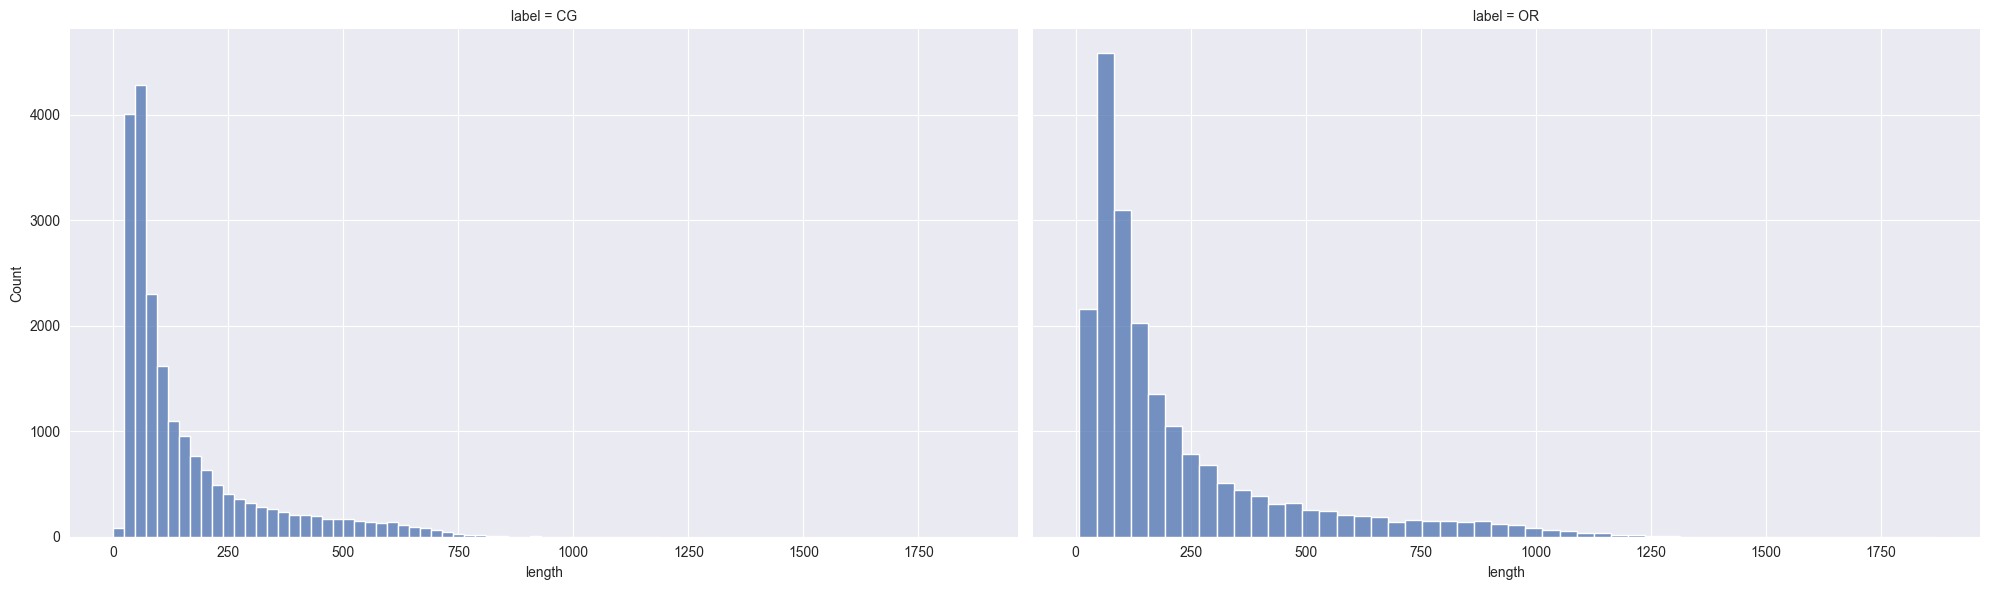

In [14]:
g = sns.FacetGrid(df, col="label", height=6, aspect=10/6)
g.map_dataframe(sns.histplot, x="length", bins=50, color ='b')
sns.despine(left=True, bottom=True)
plt.show()

## Text Processing and Feature Extraction

In [15]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

In [16]:
def process_text(review):
    no_punctuation = ''.join([char for char in review if char not in string.punctuation])
    return [word for word in no_punctuation.split() if word.lower() not in stopwords.words('english')]

### Bag of Words (BoW) transformer

In [17]:
# Creating a Bag of Words (BoW) transformer
bow_transformer = CountVectorizer(analyzer=process_text)
bow_reviews = bow_transformer.fit_transform(df['text_'])

In [18]:
# Checking the vocabulary size
vocab_size = len(bow_transformer.vocabulary_)
print("Total Vocabulary:", vocab_size)

Total Vocabulary: 37272


In [19]:
bow_transformer.fit(df['text_'])
print("Total Vocabulary:",len(bow_transformer.vocabulary_))

Total Vocabulary: 37272


In [20]:
# Transforming all reviews
bow_reviews = bow_transformer.transform(df['text_'])
print("Shape of transformed reviews:", bow_reviews.shape)
print("Non-zero occurrences:", bow_reviews.nnz)
print("Sparsity (the percentage of non-zero occurrences in the BoW matrix.): {:.2%}".format(bow_reviews.nnz / (bow_reviews.shape[0] * bow_reviews.shape[1])))

Shape of transformed reviews: (40432, 37272)
Non-zero occurrences: 1023501
Sparsity (the percentage of non-zero occurrences in the BoW matrix.): 0.07%


###  Term Frequency-Inverse Document Frequency (TF-IDF) transformer

In [21]:
tfidf_transformer = TfidfTransformer().fit(bow_reviews)

In [22]:
# Transforming all reviews
tfidf_reviews = tfidf_transformer.transform(bow_reviews)
print("Shape of transformed reviews:", tfidf_reviews.shape)
print("Number of dimensions:", tfidf_reviews.ndim)

Shape of transformed reviews: (40432, 37272)
Number of dimensions: 2


## Multi-Model Text Classification with Validation and Performance Metrics

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.preprocessing import LabelEncoder
import numpy as np

### Encoding the labels

In [24]:
le = LabelEncoder()
df['label'] = le.fit_transform(df['label'])

### Splitting the data into train, validation, and test sets

In [25]:
X_train, X_temp, y_train, y_temp = train_test_split(df['text_'], df['label'], test_size=0.3, random_state=42, stratify=df['label'])
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

### Defining the pipeline for each model

In [26]:
pipelines = {
    'Naive Bayes': Pipeline([('bow', CountVectorizer(analyzer=process_text)), ('tfidf', TfidfTransformer()), ('classifier', MultinomialNB())]),
    'SVM': Pipeline([('bow', CountVectorizer(analyzer=process_text)), ('tfidf', TfidfTransformer()), ('classifier', SVC())]),
    'Logistic Regression': Pipeline([('bow', CountVectorizer(analyzer=process_text)), ('tfidf', TfidfTransformer()), ('classifier', LogisticRegression())]),
    'Random Forest': Pipeline([('bow', CountVectorizer(analyzer=process_text)), ('tfidf', TfidfTransformer()), ('classifier', RandomForestClassifier())]),
    'XGBoost': Pipeline([('bow', CountVectorizer(analyzer=process_text)), ('tfidf', TfidfTransformer()), ('classifier', XGBClassifier())])
}

### Training the models and printing the performance metrics

Performance of Naive Bayes:
F1 Score (Micro): 0.8544105523495465
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.88      0.86      3032
           1       0.88      0.82      0.85      3033

    accuracy                           0.85      6065
   macro avg       0.86      0.85      0.85      6065
weighted avg       0.86      0.85      0.85      6065

Confusion Matrix:
 [[2682  350]
 [ 533 2500]]
Model Prediction Accuracy: 85.44%


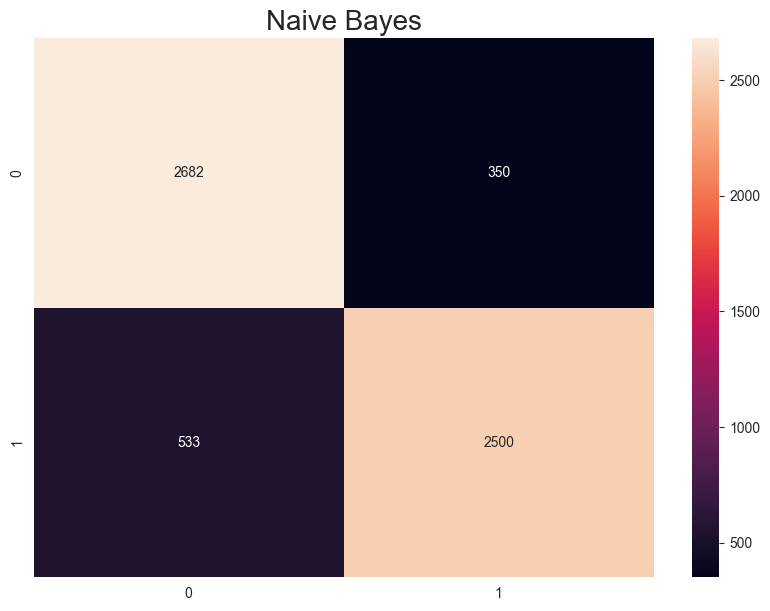

Performance of SVM:
F1 Score (Micro): 0.8827699917559769
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.87      0.88      3032
           1       0.87      0.90      0.88      3033

    accuracy                           0.88      6065
   macro avg       0.88      0.88      0.88      6065
weighted avg       0.88      0.88      0.88      6065

Confusion Matrix:
 [[2628  404]
 [ 307 2726]]
Model Prediction Accuracy: 88.28%


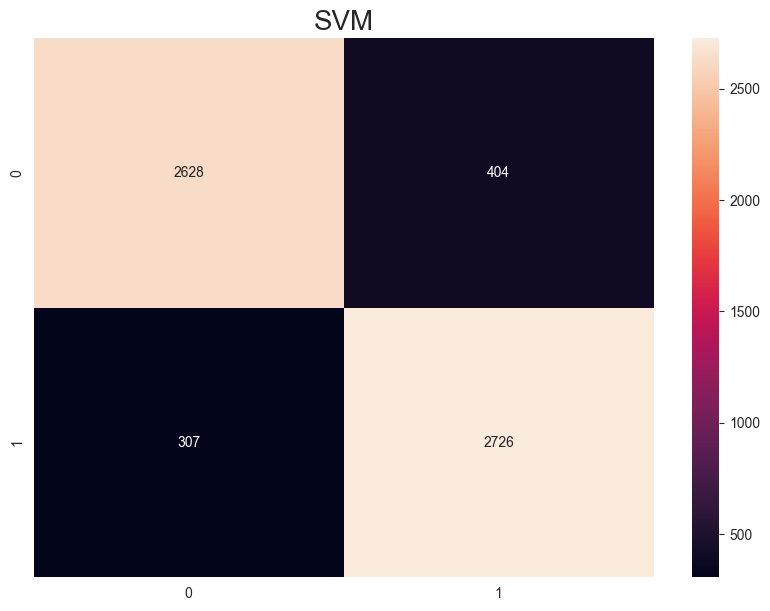

Performance of Logistic Regression:
F1 Score (Micro): 0.8700741962077494
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.86      0.87      3032
           1       0.86      0.88      0.87      3033

    accuracy                           0.87      6065
   macro avg       0.87      0.87      0.87      6065
weighted avg       0.87      0.87      0.87      6065

Confusion Matrix:
 [[2602  430]
 [ 358 2675]]
Model Prediction Accuracy: 87.01%


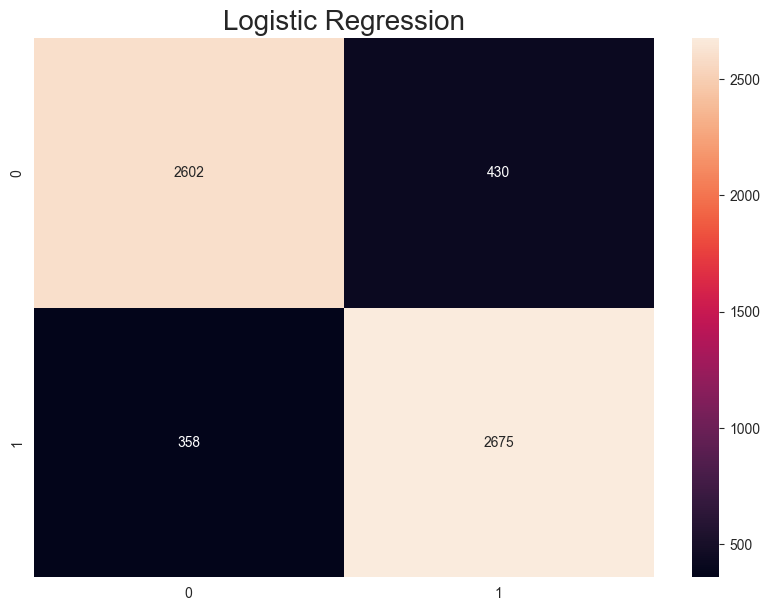

Performance of Random Forest:
F1 Score (Micro): 0.8492992580379225
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.90      0.86      3032
           1       0.89      0.80      0.84      3033

    accuracy                           0.85      6065
   macro avg       0.85      0.85      0.85      6065
weighted avg       0.85      0.85      0.85      6065

Confusion Matrix:
 [[2738  294]
 [ 620 2413]]
Model Prediction Accuracy: 84.93%


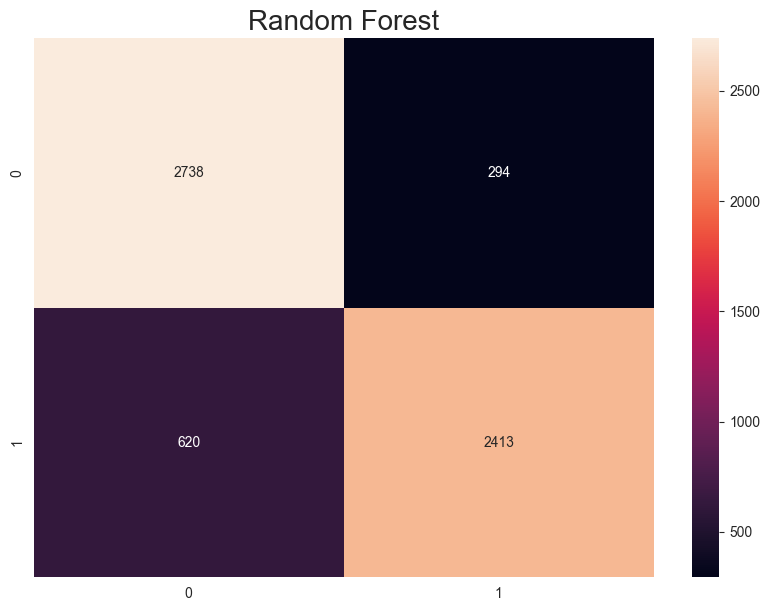

Performance of XGBoost:
F1 Score (Micro): 0.8329760923330586
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.81      0.83      3032
           1       0.82      0.85      0.84      3033

    accuracy                           0.83      6065
   macro avg       0.83      0.83      0.83      6065
weighted avg       0.83      0.83      0.83      6065

Confusion Matrix:
 [[2462  570]
 [ 443 2590]]
Model Prediction Accuracy: 83.3%


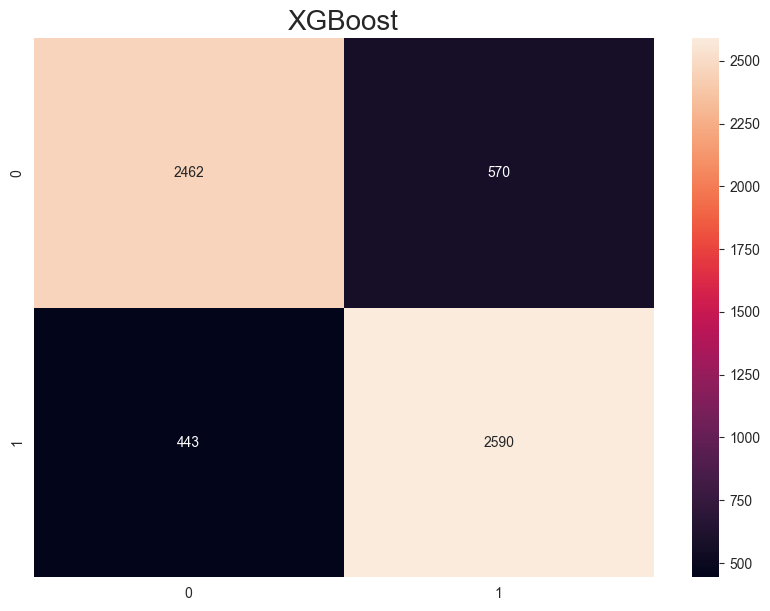

In [27]:
f1_scores = pd.DataFrame(columns=['Model', 'F1 Score (Micro)'])

for model, pipeline in pipelines.items():
    pipeline.fit(X_train, y_train)
    predictions = pipeline.predict(X_val)
    print(f'Performance of {model}:')
    f1_micro = f1_score(y_val, predictions, average='micro')
    print('F1 Score (Micro):', f1_micro)
    print('Classification Report:\n', classification_report(y_val, predictions))
    print('Confusion Matrix:\n', confusion_matrix(y_val, predictions))
    print('Model Prediction Accuracy:', str(np.round(accuracy_score(y_val, predictions)*100,2)) + '%')
    f1_scores = pd.concat([f1_scores, pd.DataFrame({'Model': [model], 'F1 Score (Micro)': [f1_micro]})], ignore_index=True)
    plt.figure(figsize=(10,7))
    sns.heatmap(confusion_matrix(y_val, predictions), annot=True, fmt='d')
    plt.title(model, fontsize=20)
    plt.show()

## The Best Model

In [28]:
f1_scores = f1_scores.sort_values(by='F1 Score (Micro)', ascending=False)
f1_scores.reset_index(drop=True, inplace=True)
f1_scores.index = range(1, len(f1_scores) + 1)

print(f1_scores)

                 Model  F1 Score (Micro)
1                  SVM          0.882770
2  Logistic Regression          0.870074
3          Naive Bayes          0.854411
4        Random Forest          0.849299
5              XGBoost          0.832976


### Testing the Best Model

In [29]:
svm_pipeline = pipelines['SVM'] 
svm_pipeline.fit(X_train, y_train)
svm_predictions = svm_pipeline.predict(X_test)
print('F1 Score (Micro) for SVM on test data:', f1_score(y_test, svm_predictions, average='micro'))

F1 Score (Micro) for SVM on test data: 0.8847485572959605
